In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (9,6)
matplotlib.rcParams['font.size'] = 18

# Loading Data and Preprocessing

### **First of all Data fromats are HIEC which must be converted to JPEG format to work with it**

In [ ]:
!pip install pyheif

     |████████████████████████████████| 8.2 MB 4.4 MB/s 


In [ ]:
!pip install imgaug


In [ ]:
!pip install whatimage

In [ ]:
!pip install split-folders

In [ ]:
import io
import whatimage
import pyheif
import splitfolders

In [4]:
import os
from PIL import Image
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet_v2 import ResNet50V2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D,BatchNormalization
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [ ]:
non_saffron_path = '/content/drive/MyDrive/SaffronSystems/Saffron iEye/Non-Saffron'
saffron_path = '/content/drive/MyDrive/SaffronSystems/Saffron iEye/Saffron'
path_to_save_saffron = '/content/drive/MyDrive/SaffronSystems/Converted_images/Saffron/'
path_to_save_nsaffron = '/content/drive/MyDrive/SaffronSystems/Converted_images/Non Saffron/'

In [ ]:
def decodeImage(bytesIo, index,flage=True):
    with open(bytesIo, 'rb') as f:
      data = f.read()
      fmt = whatimage.identify_image(data)
      if fmt in ['heic','jpg','JPG']:
        i = pyheif.read_heif(data)
        pi = Image.frombytes(mode=i.mode, size=i.size, data=i.data)
        if flage == True :
          pi.save(path_to_save_saffron + str(index) + ".jpg", format="jpeg")
        elif flage == False:
           pi.save(path_to_save_nsaffron + str(index) + ".jpg", format="jpeg")

In [ ]:
for index, file in enumerate(os.listdir(saffron_path)):
     decodeImage(os.path.join(saffron_path,file),index)

In [ ]:
for index, file in enumerate(os.listdir(non_saffron_path)):
     decodeImage(os.path.join(non_saffron_path,file),index,False)

### Splitting data into train, test and validation 

In [ ]:
data_dir = '/content/drive/MyDrive/SaffronSystems/Converted_images'
splitfolders.ratio(data_dir, output="/content/drive/MyDrive/SaffronSystems/splitted_Data", seed=1337, ratio=(.9, 0.05,0.05))

Copying files: 2034 files [01:33, 21.85 files/s]


# Building a Model

### Data Augmentation for better results :-

In [5]:
train_path = '/content/drive/MyDrive/SaffronSystems/splitted_Data/train'
test_path = '/content/drive/MyDrive/SaffronSystems/splitted_Data/test'
validation_path = '/content/drive/MyDrive/SaffronSystems/splitted_Data/val'

#### train data generator

In [6]:
train_gen = ImageDataGenerator(shear_range=0.2,
                               rescale = 1./255,
                               zoom_range=[0.5,1.0],
                               brightness_range=[0.2,1.0],
                               rotation_range=90,
                               horizontal_flip=True,
                               vertical_flip=True)

train_data = train_gen.flow_from_directory(train_path,
                                            target_size=(224, 224),
                                            class_mode='categorical',
                                            batch_size=32,
                                            shuffle=True)


Found 1627 images belonging to 2 classes.


In [7]:
batch = train_data.next()

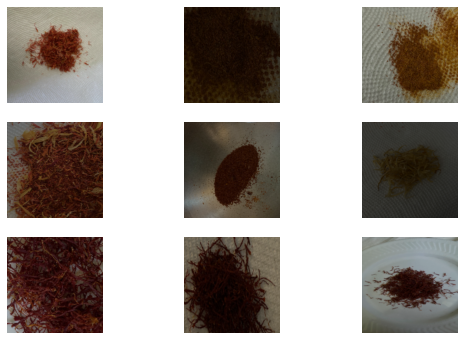

In [8]:
# generate samples and plot
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # convert to unsigned integers for viewing
  image = batch[0][i]
  # plot raw pixel data
  plt.axis('off')
  plt.imshow(image)
# show the figure
plt.show()

In [9]:
train_data.class_indices

{'Non Saffron': 0, 'Saffron': 1}

#### Test and Validation Generator

In [10]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_data = test_gen.flow_from_directory(test_path,
                                           target_size=(224, 224),
                                            class_mode='categorical',
                                            batch_size=32,
                                            shuffle=True)

val_data = test_gen.flow_from_directory(validation_path,
                                           target_size=(224, 224),
                                            class_mode='categorical',
                                            batch_size=32,
                                            shuffle=True)


Found 205 images belonging to 2 classes.
Found 202 images belonging to 2 classes.


In [11]:
x,y = train_data.next()

In [12]:
y.shape

(32, 2)

### Define a callback for model saving and restoring

In [13]:
ckp = ModelCheckpoint('/content/drive/MyDrive/SaffronSystems/Model_checkpoints/vgg_model_5.h5',
                      monitor='val_accuracy',
                      verbose=1,
                      save_best_only=True,
                      save_weights_only=False,
                      mode='max')

es = EarlyStopping(monitor='val_accuracy',
                  min_delta=0,
                  patience=5,
                  verbose=1,
                  mode='max')

### define the model 

# MobileNet


In [ ]:
base_model = MobileNetV2(input_shape=(224,224,3),
                          include_top=False,
                          weights="imagenet",
                          classes=2)
#freeze the base model layers to train only top classifier
for layer in base_model.layers:
  layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8028288   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [ ]:
# Compile model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
history =  model.fit(train_data,
                     epochs=15,
                     batch_size=64,
                     validation_data=val_data,
                     callbacks=[ckp,es])

Epoch 1/15
27/27 [==============================] - 475s 16s/step - loss: 1.8974 - accuracy: 0.7523 - val_loss: 0.4177 - val_accuracy: 0.8879

Epoch 00001: val_accuracy improved from -inf to 0.88785, saving model to /content/drive/MyDrive/SaffronSystems/Model_checkpoints/mob_net_3.h5
Epoch 2/15
27/27 [==============================] - 164s 6s/step - loss: 0.4030 - accuracy: 0.8814 - val_loss: 0.4062 - val_accuracy: 0.8692

Epoch 00002: val_accuracy did not improve from 0.88785
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.8802

KeyboardInterrupt: ignored

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
model = load_model('/content/drive/MyDrive/SaffronSystems/Model_checkpoints/model_2')
model.summary()

In [ ]:
loss, acc = model.evaluate(test_data, verbose=1)
print("trained model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
y_test=np.concatenate([test_data.next()[1] for i in range(test_data.__len__())])

In [ ]:
y_pred = model.predict_generator(test_data)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
matrix

In [ ]:

df_cm = pd.DataFrame(matrix, index = [i for i in "Saffron Non_saffron".split()],
                  columns = [i for i in "Saffron Non_saffron".split()])
sns.heatmap(df_cm,annot=True,fmt="d");

In [ ]:
sns.heatmap(matrix/sum(matrix),annot=True,fmt='.2%',cmap='Blues',xticklabels=["Saffron","Non_saffron"], yticklabels=["Saffron","Non_saffron"]);

In [ ]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

In [ ]:
model.save('/content/drive/MyDrive/SaffronSystems/Model_checkpoints/model_2',save_format='h5')